This script calculates the relative difference between the ERA5 soil moisture data and the ESA soil moisture data over the Desert Southwest

In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar

# math and data
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [39]:
# specify directories
scratch_path = '/glade/u/home/zcleveland/scratch/'  # scratch directory on NCAR
repo_path = '/glade/u/home/zcleveland/NAM_soil-moisture/'  # github repository on NCAR
era5_dsw_path = os.path.join(scratch_path, 'ERA5/dsw/')
esa_dsw_path = os.path.join(scratch_path, 'ESA_data/dsw/')
era5_regrid_path = os.path.join(scratch_path, 'ERA5/regrid-to-esa/')
corr_path = os.path.join(scratch_path, 'ERA5/correlations/regrid/')
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/correlations/regrid/'

In [2]:
# define list of variables
var_list = [
    # 'lsp',  # large scale precipitation (m of water) - accumu
    # 'cp',  # convective precipitation (m of water) - accumu
    # 'tp',  # total precipitation (m of water) - accumu -- DERIVED
    # 'sd',  # snow depth  (m of water equivalent) - instan
    # 'msl',  # mean sea level pressure (Pa) - instan
    # 'tcc',  # total cloud cover (0-1) - instan
    # 'stl1',  # soil temp layer 1 (K) - instan
    # 'stl2',  # soil temp layer 2 (K) - instan
    # 'stl3',  # soil temp layer 3 (K) - instan
    # 'stl4',  # soil temp layer 4 (K) - instan
    'swvl1',  # soil volume water content layer 1 (m^3 m^-3) - instan
    # 'swvl2',  # soil volume water content layer 2 (m^3 m^-3) - instan
    # 'swvl3',  # soil volume water content layer 3 (m^3 m^-3) - instan
    # 'swvl4',  # soil volume water content layer 4 (m^3 m^-3) - instan
    # '2t',  # 2 meter temp (K) - instan
    # '2d',  # 2 meter dew point (K) - instan
    # 'ishf',  # instant surface heat flux (W m^-2) - instan
    # 'ie',  # instant moisture flux (kg m^-2 s^-1) - instan
    # 'sshf',  # surface sensible heat flux (J m^-2) - accumu
    # 'slhf',  # surface latent heat flux (J m^-2) - accumu
    # 'ssr',  # surface net solar radiation (J m^-2) - accumu
    # 'str',  # surface net thermal radiation (J m^-2) - accumu
    # 'sro',  # surface runoff (m) - accumu
    # 'sf',  # total snowfall (m of water equivalent) - accumu
    # 'cape',  # convective available potential energy (J kg^-1) - instan
    # 'tcw',  # total column water (kg m^-2) - sfc (sum total of solid, liquid, and vapor in a column)
    # 'ssrd',  # surface solar radiation downwards (J m^-2) - accumu
    # 'strd',  # surface thermal radiation downwards (J m^-2) - accumu
]

In [25]:
# define a function to calculate the percentage difference between ERA5 and ESA soil moisture
def percent_diff_ERA5_ESA(year=1980):
    # create filename and path and check for existence
    out_fn = f'diff_ERA5_ESA_{year}01_{year}12_dsw.nc'
    out_fp = os.path.join(era5_regrid_path, str(year), out_fn)
    if os.path.exists(out_fp):
        print(f'{out_fn} already exists.  Skipping . . .\n')
        return
    else:
        print(f'Processing year: {year}\n')

    # open datasets
    era5_ds = xr.open_dataset(os.path.join(era5_regrid_path, str(year), f'swvl1_{year}01_{year}12_regrid.nc'))
    esa_ds = xr.open_dataset(os.path.join(esa_dsw_path, f'ESA_COMBINED_sm_{year}01_{year}12_dsw.nc'))

    # grab data inside
    era5_da = era5_ds['SWVL1_AVG']
    esa_da = esa_ds['sm']

    # calculate percent difference
    abs_diff = np.abs(era5_da - esa_da)  # absolute difference
    avg_value = (era5_da + esa_da) / 2  # average of the two datasets
    percent_diff = (abs_diff / avg_value) * 100

    # save to netcdf
    percent_diff.to_netcdf(out_fp)

In [ ]:
# run the code
if __name__ == '__main__':
    for year in range(1980,2020):
        # percent_diff_ERA5_ESA(year=year)

In [34]:
# define a function to calculate the correlation between ERA5 and ESA soil moisture
def calc_corr_ERA5_ESA():
    # create filename and path and check for existence
    out_fn = f'corr_ERA5_ESA_198001_201912_dsw.nc'
    out_fp = os.path.join(corr_path, out_fn)
    if os.path.exists(out_fp):
        print(f'{out_fn} already exists.  Skipping . . .\n')
        return
    else:
        print(f'Processing . . .\n')

    # get filepaths
    era_files = glob.glob(f'{era5_regrid_path}*/*swvl1*.nc')
    esa_files = glob.glob(f'{esa_dsw_path}*ESA*.nc')

    # sort files
    era_files.sort()
    esa_files.sort()
    
    # open datasets
    era5_ds = xr.open_mfdataset(era_files)
    esa_ds = xr.open_mfdataset(esa_files)

    # grab data inside
    era5_da = era5_ds['SWVL1_AVG']
    esa_da = esa_ds['sm']

    # calculate correlation
    corr = xr.corr(era5_da, esa_da, dim='time')

    # save to netcdf
    corr.to_netcdf(out_fp)

In [ ]:
if __name__ == '__main__':
    calc_corr_ERA5_ESA()

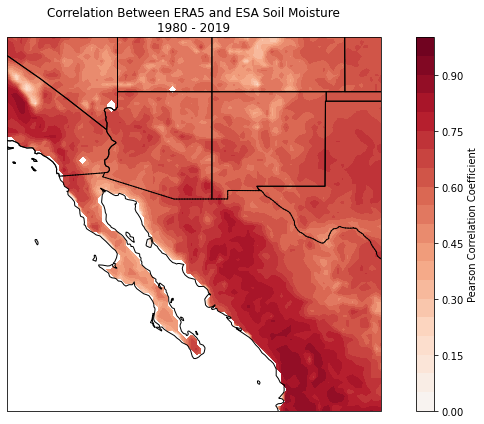

In [42]:
# plot results
projection = ccrs.PlateCarree()    
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))

levels = np.arange(0, 1.05, 0.05) 
# plot the data using contourf
cf = plt.contourf(corr.longitude, corr.latitude,
                  corr, levels=levels,
                  cmap='RdBu_r', vmin=-1, vmax=1)    

# add coastlines, state borders, and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES)

# plot features
plt.title(f'Correlation Between ERA5 and ESA Soil Moisture\n1980 - 2019')    
plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient')
plt.tight_layout()
plt.savefig(f'{plot_out_path}corr_swvl1_sm.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()